In [1]:
!pip install tensorflow==2.13.0 numpy==1.24.3 pandas==1.5.3 opencv-python==4.8.0.76 matplotlib==3.7.1 scikit-learn==1.2.2


INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 24.1 MB/s eta 0:00:0

In [5]:
!unzip -q /content/data.zip -d /content/data

In [4]:
import os
print(os.getpid())


725


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_path = "/content/data/data/driving_log.csv"
df = pd.read_csv(csv_path, header=None)

# Build image paths
image_paths = [
    os.path.join("/content/data/data/IMG", os.path.basename(p.strip().replace('\\', '/')))
    for p in df[0]
]

# Steering angles
steering_angles = df[3].astype('float32')

# Train-test split
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, steering_angles, test_size=0.2, random_state=42
)

print(f"Train samples: {len(X_train_paths)}, Test samples: {len(X_test_paths)}")

Train samples: 9788, Test samples: 2448


In [3]:
def preprocess_image(img_path):
    """Load and preprocess image from file path."""
    image = cv2.imread(img_path)
    if image is None:
        return None
    # Crop road area
    cropped = image[60:135, :, :]
    # Convert to YUV
    yuv_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2YUV)
    # Resize
    resized = cv2.resize(yuv_image, (200, 66))
    # Gaussian blur
    blurred = cv2.GaussianBlur(resized, (3, 3), 0)
    # Normalize to [0,1]
    normalized = blurred.astype('float32') / 255.0
    return normalized

def augment_image(img, steering_angle):
    """Random augmentations for training."""
    # Horizontal flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering_angle = -steering_angle

    # Brightness
    if np.random.rand() < 0.5:
        img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_YUV2BGR)
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * ratio, 0, 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV) / 255.0

    # Zoom
    if np.random.rand() < 0.5:
        zoom = np.random.uniform(1.0, 1.2)
        h, w, _ = img.shape
        new_h, new_w = int(h / zoom), int(w / zoom)
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        img = img[top:top+new_h, left:left+new_w]
        img = cv2.resize(img, (w, h))

    # Pan
    if np.random.rand() < 0.5:
        h, w, _ = img.shape
        tx = np.random.randint(-20, 20)
        ty = np.random.randint(-20, 20)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv2.warpAffine(img, M, (w, h))

    # Rotation
    if np.random.rand() < 0.5:
        h, w, _ = img.shape
        angle = np.random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h))

    return img, steering_angle



In [4]:
# === Generators for training and validation ===
# Train generator loads images, augments them, and yields batches
# Validation generator loads images without augmentation

def train_generator(X_paths, y, batch_size):
    num_samples = len(X_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_idx = indices[offset:offset+batch_size]
            batch_images, batch_angles = [], []
            for i in batch_idx:
                img = preprocess_image(X_paths[i])
                if img is None:
                    continue
                img, angle = augment_image(img, y.iloc[i])
                batch_images.append(img)
                batch_angles.append(angle)
            yield np.array(batch_images), np.array(batch_angles)

def val_generator(X_paths, y, batch_size):
    num_samples = len(X_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_idx = range(offset, min(offset+batch_size, num_samples))
            batch_images, batch_angles = [], []
            for i in batch_idx:
                img = preprocess_image(X_paths[i])
                if img is None:
                    continue


In [6]:
# Classic architecture for end-to-end self-driving control

model = Sequential([
    layers.Lambda(lambda x: x, input_shape=(66, 200, 3)),
    layers.Conv2D(24, (5, 5), strides=(2, 2), activation='relu'),
    layers.Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    layers.Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(1164, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1164)           │     1,342,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       116,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,511 (6.09 MB)

 Trainable params: 1,595,511 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
batch_size = 64
epochs = 15

steps_per_epoch = len(X_train_paths) // batch_size
validation_steps = len(X_test_paths) // batch_size

history = model.fit(
    train_generator(X_train_paths, y_train, batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator(X_test_paths, y_test, batch_size),
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - loss: 0.0430 - mae: 0.0926 - val_loss: 0.0376 - val_mae: 0.0955
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0404 - mae: 0.1090 - val_loss: 0.0354 - val_mae: 0.1017
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.0385 - mae: 0.1084 - val_loss: 0.0340 - val_mae: 0.1129
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.0359 - mae: 0.1073 - val_loss: 0.0325 - val_mae: 0.0973
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.0374 - mae: 0.1106 - val_loss: 0.0329 - val_mae: 0.1048
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - loss: 0.0370 - mae: 0.1094 - val_loss: 0.0315 - val_mae: 0.1027
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - loss: 0.0352 - mae: 0.1074 - val_loss: 0.0310 - val_mae: 0.1020
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.0355 - mae: 0.1082 - val_loss: 0.0321 - val_mae: 0.1061
Epoch 9/15
152/152 ━━━━━━━━━━━━━

[INFO] Training history plot saved as training_history.png


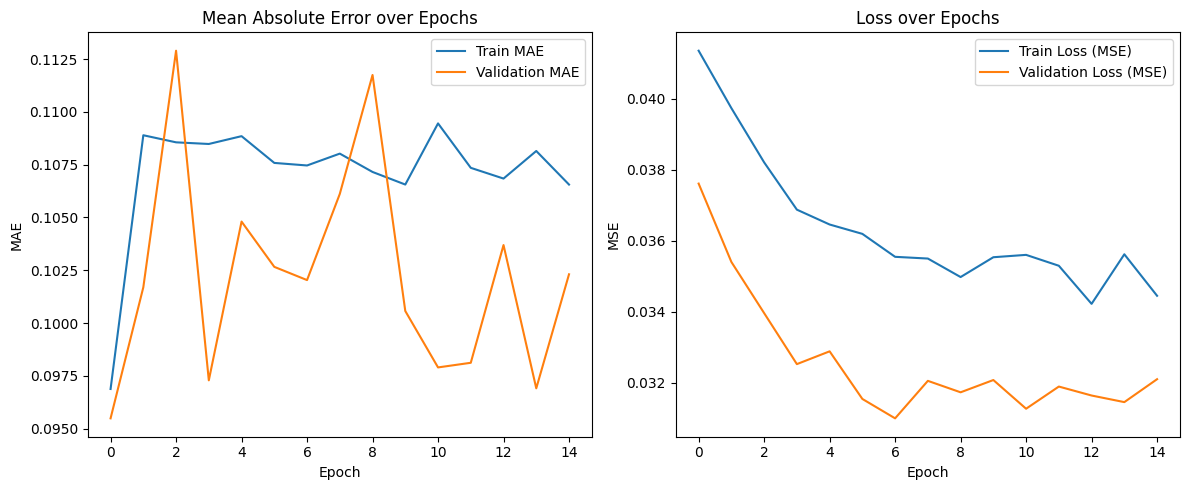

In [8]:
# === Plot training history and save the figure ===
# Shows MAE and loss curves for both training and validation
# Saves the figure as 'training_history.png' in the current directory

plt.figure(figsize=(12, 5))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig("training_history.png", dpi=300)
print("[INFO] Training history plot saved as training_history.png")

# Display the plot
plt.show()


In [10]:
model.save("Self_model.h5")
print("Model saved as Self_model.h5")


Model saved as Self_model.h5
